# Deep Learning Project 4a - Computer Vision Multi-Classification and                                                                  Multi-Layer Convolutional Neural Network Model

Previously, pickle files were formatted datasets for training, development and testing on the CIFAR10 dataset (32 x 32 image size). The goal of this project is to train a convolutional neural network model using TensorFlow with an image pipeline, one(1) channel, five (5) layers [two(2) convoluational; three (3) fully connected], depth of 5, and 3 by 3 patch filter size.

In [1]:
# Import required modules
import os
import sys
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from six.moves import urllib
from tensorflow.python.framework import ops

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
batch_size = 128
image_height = 32
image_width = 32
num_channels = 3
num_targets = 10

In [3]:
image_vec_length = image_height*image_width*num_channels
record_length = 1 + image_vec_length

In [4]:

data_dir = 'temp_cifar'
if not os.path.exists(data_dir):
    print('Make temp directory at code root directory location')
    os.makedirs(data_dir)
cifar10_url = 'http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'
data_file = os.path.join(data_dir,'cifar-10-binary.tar.gz')
if not os.path.isfile(data_file):
    # Download cifar10 file
    filepath, _ = urllib.request.urlretrieve(cifar10_url, data_file)
    # Extract file
    tarfile.open(filepath, 'r:gz').extractall(data_dir)


In [5]:
crop_height = 24
crop_width = 24

def read_cifar_files(filename_queue, distort_images =True):
    reader = tf.FixedLengthRecordReader(record_bytes=record_length)
    key, record_string = reader.read(filename_queue)
    record_bytes = tf.decode_raw(record_string, tf.uint8)
    
    # Extract label
    image_label = tf.cast(tf.slice(record_bytes, [0],[1]),tf.int32)
    
    # Extract image
    image_extracted = tf.reshape(tf.slice(record_bytes, [1],[image_vec_length]),[num_channels, image_height, image_width])
    
    #Reshape image
    image_uint8image = tf.transpose(image_extracted, [1,2,0])
    reshaped_image = tf.cast(image_uint8image, tf.float32)
    
    #Crop image to 24 by 24
    final_image = tf.image.resize_image_with_crop_or_pad(reshaped_image, crop_width, crop_height)
    # Change the image characteristics to effectively increase the training dataset size
    if distort_images:
        # Randomly flip (1 in 2 chance) the image horizontally along the width
        final_image = tf.image.random_flip_left_right(final_image)
        # Randomly change the image brightness
        final_image = tf.image.random_brightness(final_image, max_delta=63)
        # Randomly change the image contrast
        final_image = tf.image.random_contrast(final_image, lower = 0.2, upper = 1.8)
    #Normalize whitening with standardization
    final_image = tf.image.per_image_standardization(final_image)
    return (final_image, image_label)
        
    

In [6]:
extract_folder = 'cifar-10-batches-bin'
def input_pipeline(batch_size, train_logical = True):
    if train_logical:
        files = [os.path.join(data_dir, extract_folder, 'data_batch_{}.bin'.format(i)) for i in range(1,6)]
    else:
        files = [os.path.join(data_dir, extract_folder, 'test_batch.bin')]
    filename_queue = tf.train.string_input_producer(files)
    image, label = read_cifar_files(filename_queue)
    min_after_dequeue = 1000
    capacity = min_after_dequeue + (3*batch_size)
    example_batch, label_batch = tf.train.shuffle_batch([image,label], batch_size, capacity, min_after_dequeue)
    return (example_batch, label_batch)

In [7]:
patch_filter_size = 3


def cifar_cnn_model(input_images, batch_size, train_logical = True):
    def truncated_normal_var(name, shape, dtype):
        return (tf.get_variable(name = name, shape = shape, dtype = dtype,\
                                initializer=tf.truncated_normal_initializer(stddev = 0.05)))
    def zero_var(name, shape, dtype):
        return (tf.get_variable(name = name, shape = shape, dtype = dtype,\
                                initializer=tf.constant_initializer(0.0)))
    
    # First Convolutional layer
    with tf.variable_scope('conv1') as scope:
        # Establish and initialize 3 by 3 convolutional kernel (filter) with random values
        # for all 3 channel colors for 64 features
        conv1_kernel = truncated_normal_var(name = 'conv1_kernel', shape = [patch_filter_size,patch_filter_size,3,64],\
                                            dtype = tf.float32)
        
        # Convolve across image with a stride size of one(1)
        conv1 = tf.nn.conv2d(input_images, conv1_kernel, [1,1,1,1], padding = 'SAME')
        
        # Establish and initialize the first layer bias terms with random value 
        conv1_bias = zero_var(name = 'conv1_bias', shape = [64], dtype = tf.float32)
        
        # Add first layer bias terms
        conv1_add_bias = tf.nn.bias_add(conv1, conv1_bias)
        
        # Apply rectified linear unit activation function (ReLU) element-wise
        relu_conv1 = tf.nn.relu(conv1_add_bias)
        
        # Apply max pooling
        max_pool1 = tf.nn.max_pool(relu_conv1, ksize = [1,3,3,1], strides = [1,2,2,1], padding = 'SAME', name = 'pool_layer1')
        
        # Local response normalization
        norm1 = tf.nn.lrn(max_pool1, depth_radius = 5, bias = 2.0, alpha = 1e-3, beta = 0.75, name = 'norm1')
        
    # Second Convolutional layer
    with tf.variable_scope('conv2') as scope:
        # Establish and initialize 3 by 3 convolutional kernel (filter) with random values
        # with previous 64 features and 64 newly created features
        conv2_kernel = truncated_normal_var(name = 'conv2_kernel', shape = [patch_filter_size,patch_filter_size,64,64],\
                                            dtype = tf.float32)
        
        # Convolve across image with a stride size of one(1)
        conv2 = tf.nn.conv2d(norm1, conv2_kernel, [1,1,1,1], padding = 'SAME')
        
        # Establish and initialize the first layer bias terms with random value 
        conv2_bias = zero_var(name = 'conv2_bias', shape = [64], dtype = tf.float32)
        
        # Add first layer bias terms
        conv2_add_bias = tf.nn.bias_add(conv2, conv2_bias)
        
        # Apply rectified linear unit activation function (ReLU) element-wise
        relu_conv2 = tf.nn.relu(conv2_add_bias)
        
        # Apply max pooling
        max_pool2 = tf.nn.max_pool(relu_conv2, ksize = [1,3,3,1], strides = [1,2,2,1], padding = 'SAME', name = 'pool_layer2')
        
        # Local response normalization
        norm2 = tf.nn.lrn(max_pool2, depth_radius = 5, bias = 2.0, alpha = 1e-3, beta = 0.75, name = 'norm2')
        
        # Reshape last convolution layer output for input to fully connected layers
        reshaped_conv_output = tf.reshape(norm2, [batch_size, -1])
        reshaped_conv_output_dim = reshaped_conv_output.get_shape()[1].value
        
        # First Fully Connected Layer
        with tf.variable_scope('full1') as scope:
            # Fully connected layer with 384 output hidden nodes
            # Define number of hidden nodes in first fully connected layer
            hidden_nodes1 = 384
            # Establish and initialize the first fully connected layer weights with random values
            full_weight1 = truncated_normal_var(name = 'full_mult1',shape = [reshaped_conv_output_dim, hidden_nodes1],\
                                                dtype = tf.float32)
            # Establish and initialize the first fully connected layer bias with random values
            full_bias1 = zero_var(name = 'full_bias1',shape = [hidden_nodes1], dtype = tf.float32)
            full_layer1_logits = tf.add(tf.matmul(reshaped_conv_output, full_weight1), full_bias1)
            full_layer1 = tf.nn.relu(full_layer1_logits)
            
            
        # Second Fully Connected Layer
        with tf.variable_scope('full2') as scope:
            # Fully connected layer with 192 output hidden nodes
            # Define number of hidden nodes in first fully connected layer
            hidden_nodes2 = 192
            # Establish and initialize the second fully connected layer weights with random values
            full_weight2 = truncated_normal_var(name = 'full_mult2',shape = [hidden_nodes1, hidden_nodes2],\
                                                dtype = tf.float32)
            # Establish and initialize the first fully connected layer bias with random values
            full_bias2 = zero_var(name = 'full_bias2',shape = [hidden_nodes2], dtype = tf.float32)
            full_layer2_logits = tf.add(tf.matmul(full_layer1, full_weight2), full_bias2)
            full_layer2 = tf.nn.relu(full_layer2_logits)
    
        # Third and Final Fully Connected Layer
        with tf.variable_scope('full3') as scope:
            # Fully connected layer with 10 classification labels
            # Define number of output target in last fully connected layer
            num_targets = 10
            # Establish and initialize the third fully connected layer weights with random values
            full_weight3 = truncated_normal_var(name = 'full_mult3',shape = [hidden_nodes2, num_targets],\
                                                dtype = tf.float32)
            # Establish and initialize the first fully connected layer bias with random values
            full_bias3 = zero_var(name = 'full_bias3',shape = [num_targets], dtype = tf.float32)
            full_layer3_logits = tf.add(tf.matmul(full_layer2, full_weight3), full_bias3)

    return (full_layer3_logits)    

In [8]:
def cifar_loss(logits, targets):
    # Squeeze out extra dimensions and cast targets for integers
    targets = tf.squeeze(tf.cast(targets, tf.int32))
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = targets, logits = logits)
    cross_entropy_mean = tf.reduce_mean(cross_entropy)
    return (cross_entropy_mean)

In [9]:
"""Define the training step function"""

# Establish the values for the learning rate function
learning_rate = 0.1
lr_decay = 0.9
num_gens_to_wait = 250

def train_step(loss_value, generation_num):
    # Establish learning rate with exponential decay
    model_learning_rate = tf.train.exponential_decay(learning_rate,\
                                                     generation_num, num_gens_to_wait, lr_decay, staircase=True)
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate = model_learning_rate)
    train_step = my_optimizer.minimize(loss_value)
    return (train_step)
    

In [10]:
def accuracy_of_batch(logits, targets):
    # Squeeze out extra dimensions and cast targets for integers
    targets = tf.squeeze(tf.cast(targets, tf.int32))
    # Determine the predicted values by finding which logit is the greatest
    batch_predictions = tf.cast(tf.argmax(logits,1), tf.int32)
    predicted_correctly = tf.equal(batch_predictions, targets)
    accuracy = tf.reduce_mean(tf.cast(predicted_correctly, tf.float32))
    return (accuracy)
    

In [11]:
"""Initial training and test image pipeline functions"""
images, targets = input_pipeline(batch_size, train_logical = True)
test_images, test_targets = input_pipeline(batch_size, train_logical = False)

with tf.variable_scope('model_definition') as scope:
    model_output = cifar_cnn_model(images, batch_size)
    scope.reuse_variables()
    test_output = cifar_cnn_model(test_images, batch_size)

loss = cifar_loss(model_output, targets)
accuracy = accuracy_of_batch(test_output, test_targets)
generation_num = tf.Variable(0, trainable = False)
train_op = train_step(loss, generation_num)


In [12]:
"""Train and test 2 convolution layer/3 fully connected layer neural network"""
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
tf.train.start_queue_runners(sess = sess)

train_loss_list = []
test_accuracy_list = []

generations = 20000
output_every = 50
eval_every = 500

# loop to train and test CNN model
for i in range(generations):
    _, loss_value = sess.run([train_op, loss])
    if ((i+1) % output_every == 0):
        train_loss_list.append(loss_value)
        print('Generation {}: Loss = {:.5f}'.format((i+1),loss_value))
    if ((i+1) % eval_every == 0):
        [temp_accuracy] = sess.run([accuracy])
        test_accuracy_list.append(temp_accuracy)
        print('--- Test Accuracy = {:.2f}%'.format(100*temp_accuracy))

Generation 50: Loss = 2.21052
Generation 100: Loss = 1.91935
Generation 150: Loss = 1.82570
Generation 200: Loss = 1.66090
Generation 250: Loss = 1.56602
Generation 300: Loss = 1.64866
Generation 350: Loss = 1.73280
Generation 400: Loss = 1.69655
Generation 450: Loss = 1.47424
Generation 500: Loss = 1.46204
--- Test Accuracy = 45.31%
Generation 550: Loss = 1.39565
Generation 600: Loss = 1.44940
Generation 650: Loss = 1.50751
Generation 700: Loss = 1.38659
Generation 750: Loss = 1.34473
Generation 800: Loss = 1.64475
Generation 850: Loss = 1.38174
Generation 900: Loss = 1.44372
Generation 950: Loss = 1.45308
Generation 1000: Loss = 1.12614
--- Test Accuracy = 50.00%
Generation 1050: Loss = 1.12176
Generation 1100: Loss = 1.22427
Generation 1150: Loss = 1.17860
Generation 1200: Loss = 1.13623
Generation 1250: Loss = 1.18104
Generation 1300: Loss = 1.22290
Generation 1350: Loss = 1.12261
Generation 1400: Loss = 1.30153
Generation 1450: Loss = 1.18898
Generation 1500: Loss = 1.24920
--- Te

Generation 11900: Loss = 0.25389
Generation 11950: Loss = 0.22268
Generation 12000: Loss = 0.11362
--- Test Accuracy = 71.88%
Generation 12050: Loss = 0.13934
Generation 12100: Loss = 0.14836
Generation 12150: Loss = 0.09640
Generation 12200: Loss = 0.06372
Generation 12250: Loss = 0.18502
Generation 12300: Loss = 0.17470
Generation 12350: Loss = 0.25842
Generation 12400: Loss = 0.18102
Generation 12450: Loss = 0.10055
Generation 12500: Loss = 0.06875
--- Test Accuracy = 71.88%
Generation 12550: Loss = 0.07669
Generation 12600: Loss = 0.16684
Generation 12650: Loss = 0.17401
Generation 12700: Loss = 0.05331
Generation 12750: Loss = 0.16286
Generation 12800: Loss = 0.20943
Generation 12850: Loss = 0.10481
Generation 12900: Loss = 0.16588
Generation 12950: Loss = 0.07238
Generation 13000: Loss = 0.13242
--- Test Accuracy = 79.69%
Generation 13050: Loss = 0.23821
Generation 13100: Loss = 0.18970
Generation 13150: Loss = 0.17769
Generation 13200: Loss = 0.12762
Generation 13250: Loss = 0.1

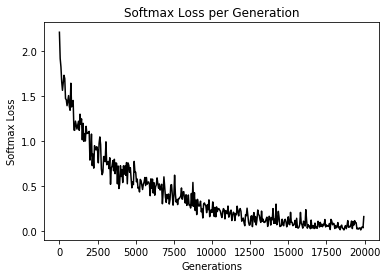

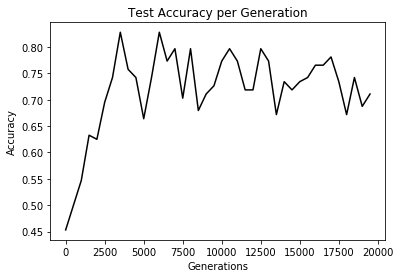

In [13]:
"""Visualize model loss and performance"""
eval_indices = list(range(0, generations, eval_every))
output_indices = list(range(0, generations, output_every))
plt.plot(output_indices, train_loss_list, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generations')
plt.ylabel('Softmax Loss')
plt.show()
plt.plot(eval_indices, test_accuracy_list, 'k-')
plt.title('Test Accuracy per Generation')
plt.xlabel('Generations')
plt.ylabel('Accuracy')
plt.show()

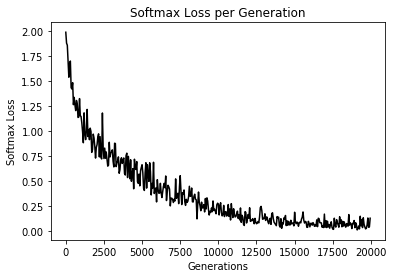

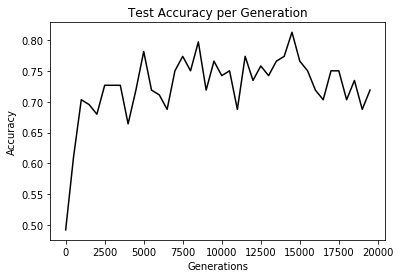

In [14]:
"""Visualize model loss and performance"""
eval_indices = list(range(0, generations, eval_every))
output_indices = list(range(0, generations, output_every))
plt.plot(output_indices, train_loss_list, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generations')
plt.ylabel('Softmax Loss')
plt.show()
plt.plot(eval_indices, test_accuracy_list, 'k-')
plt.title('Test Accuracy per Generation')
plt.xlabel('Generations')
plt.ylabel('Accuracy')
plt.show()